# Multitask GP Regression using pymc with GP LatentKron
Data Source: https://docs.gpytorch.ai/en/latest/examples/03_Multitask_Exact_GPs/Multitask_GP_Regression.html

In [1]:
import numpy as np
import pymc as pm
from pymc.gp.cov import Covariance
import arviz as az
import matplotlib.pyplot as plt
# set the seed
np.random.seed(1)

In [2]:
import math
%matplotlib inline
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

### Set up training data: same X, three Y outputs

In [3]:
train_x = np.linspace(0, 1, 50)

train_y = np.stack([
    np.sin(train_x * (2 * math.pi)) + np.random.randn(len(train_x)) * 0.2,
    np.cos(train_x * (2 * math.pi)) + np.random.randn(len(train_x)) * 0.2,
    np.cos(train_x * (1 * math.pi)) + np.random.randn(len(train_x)) * 0.1,
], -1)

In [4]:
train_x.shape, train_y.shape

((50,), (50, 3))

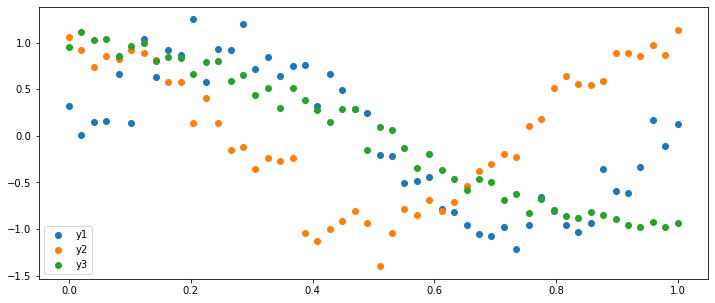

In [5]:
fig, ax = plt.subplots(1,1, figsize=(12,5))
ax.scatter(train_x, train_y[:,0])
ax.scatter(train_x, train_y[:,1])
ax.scatter(train_x, train_y[:,2])
plt.legend(["y1", "y2", "y3"])

In [6]:
train_x.shape, train_y.shape

((50,), (50, 3))

In [7]:
x = train_x.reshape(-1,1)
y = train_y.reshape(-1,1)
x.shape, y.shape

((50, 1), (150, 1))

In [8]:
task_i = np.linspace(0, 2, 3)[:, None]
Xs = [x, task_i] # For training
Xs[0].shape, Xs[1].shape, x.shape

((50, 1), (3, 1), (50, 1))

In [9]:
Xnew = pm.math.cartesian(x, task_i) # For prediction
Xnew.shape

(150, 2)

### Option 1: Implement ICM (one kernel) by using LatentKron with Coregion kernel

$$
K = K_1(x, x') \otimes K_2(o, o')
$$

#### Create a model

In [10]:
with pm.Model() as model:
    # Kernel: K_1(x,x')
    ell = pm.Gamma("ell", alpha=2, beta=0.5)
    eta = pm.Gamma("eta", alpha=3, beta=1)
    cov = eta**2 * pm.gp.cov.ExpQuad(input_dim=1, ls=ell)
    
    # Coregion B matrix: K_2(o,o')
    W = pm.Normal("W", mu=0, sigma=3, shape=(3,2), initval=np.random.randn(3,2))
    kappa = pm.Gamma("kappa", alpha=1.5, beta=1, shape=3)
    coreg = pm.gp.cov.Coregion(input_dim=1, kappa=kappa, W=W)
    
    # Specify the GP.  The default mean function is `Zero`.
    mogp = pm.gp.LatentKron(cov_funcs=[cov, coreg])
    
    sigma = pm.HalfNormal("sigma", sigma=3)
    # Place a GP prior over thXse function f.
    f = mogp.prior("f", Xs=Xs)
    y_ = pm.Normal("y_", mu=f, sigma=sigma, observed=y.squeeze())    

In [11]:
coreg.full(task_i).eval()

array([[ 18.37124704, -17.54120739,  22.65498294],
       [-17.54120739,  20.99421866, -24.94453555],
       [ 22.65498294, -24.94453555,  37.55454919]])

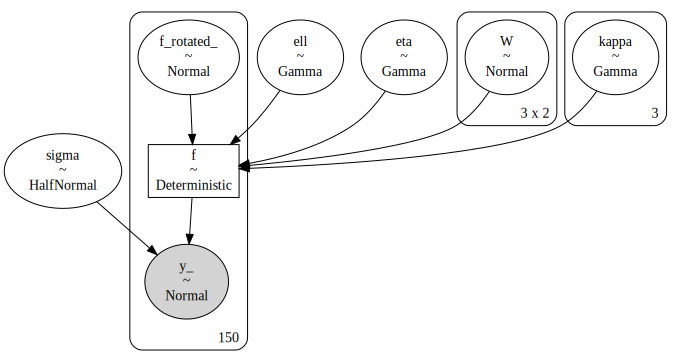

In [12]:
pm.model_to_graphviz(model)

In [13]:
%%time
with model:
    gp_trace = pm.sample(500, chains=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [ell, eta, W, kappa, sigma, f_rotated_]


Sampling 1 chain for 1_000 tune and 500 draw iterations (1_000 + 500 draws total) took 291 seconds.
There were 33 divergences after tuning. Increase `target_accept` or reparameterize.


CPU times: user 11min 41s, sys: 25min 36s, total: 37min 17s
Wall time: 4min 59s


#### Prediction

In [14]:
with model:
    preds = mogp.conditional("preds", Xnew, jitter=1e-6)
    gp_samples = pm.sample_posterior_predictive(gp_trace, var_names=['preds'])

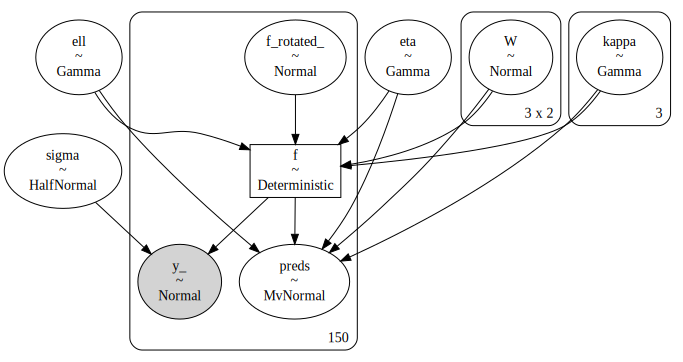

In [15]:
pm.model_to_graphviz(model)

In [16]:
f_pred = gp_samples.posterior_predictive["preds"].sel(chain=0)
f_pred.shape

(500, 150)

#### Plot the first GP

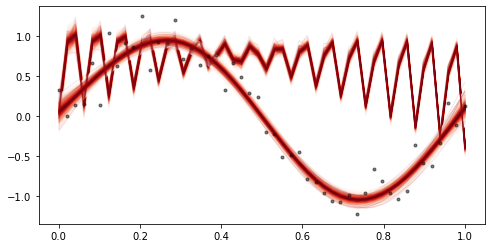

In [17]:
from pymc.gp.util import plot_gp_dist
fig, axes = plt.subplots(1,1, figsize=(8,4))
plt.plot(x, train_y[:,0], 'ok', ms=3, alpha=0.5, label="Data 1");
plot_gp_dist(axes, f_pred[:, 0:50], x)
plot_gp_dist(axes, f_pred[:,Xnew[:,1] == 0], x)
plt.show()

#### Plot the second GP

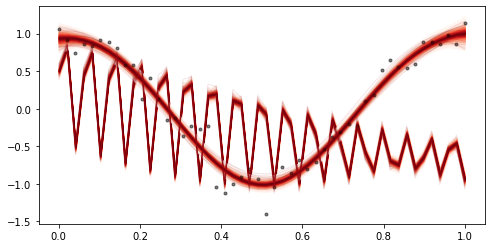

In [18]:
from pymc.gp.util import plot_gp_dist
fig, axes = plt.subplots(1,1, figsize=(8,4))
plt.plot(x, train_y[:,1], 'ok', ms=3, alpha=0.5, label="Data 1");
plot_gp_dist(axes, f_pred[:, 50:100], x)
plot_gp_dist(axes, f_pred[:,Xnew[:,1] == 1], x)
plt.show()

### Option 2.1: Implement ICM (one kernel) by using pm.gp.cov.Kron with pm.gp.Marginal

In [19]:
X = pm.math.cartesian(x, task_i)
x.shape, task_i.shape, X.shape

((50, 1), (3, 1), (150, 2))

In [20]:
with pm.Model() as model:
    ell = pm.Gamma("ell", alpha=2, beta=0.5)
    eta = pm.Gamma("eta", alpha=3, beta=1)
    cov = eta**2 * pm.gp.cov.ExpQuad(1, ls=ell)
    
    W = pm.Normal("W", mu=0, sigma=3, shape=(3,2), initval=np.random.randn(3,2))
    kappa = pm.Gamma("kappa", alpha=1.5, beta=1, shape=3)
    coreg = pm.gp.cov.Coregion(input_dim=1, kappa=kappa, W=W)    
    
    cov_func = pm.gp.cov.Kron([cov, coreg])    
    sigma = pm.HalfNormal("sigma", sigma=3)    
    gp = pm.gp.Marginal(cov_func=cov_func)    
    y_ = gp.marginal_likelihood("f", X, y.squeeze(), noise=sigma)

In [21]:
cov(x).eval().shape, coreg(task_i).eval().shape, cov_func(X).eval().shape

((50, 50), (3, 3), (150, 150))

In [22]:
%%time
with model:
    gp_trace = pm.sample(500, chains=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [ell, eta, W, kappa, sigma]


Sampling 1 chain for 1_000 tune and 500 draw iterations (1_000 + 500 draws total) took 95 seconds.


CPU times: user 4min 34s, sys: 8min 3s, total: 12min 38s
Wall time: 1min 40s


#### Prediction

In [23]:
xnew = np.linspace(-0.5, 1.5, 200)
Xnew = pm.math.cartesian(xnew, task_i)

In [24]:
with model:
    preds = gp.conditional("preds", Xnew, jitter=1e-6)
    gp_samples = pm.sample_posterior_predictive(gp_trace, var_names=['preds'])

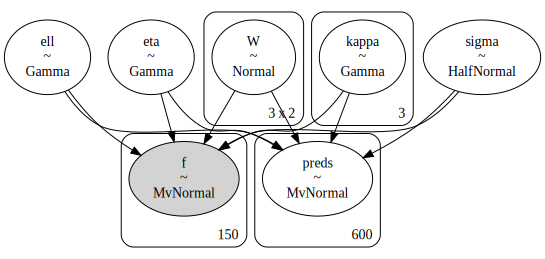

In [25]:
pm.model_to_graphviz(model)

In [26]:
Xnew.shape

(600, 2)

In [27]:
f_pred = gp_samples.posterior_predictive["preds"].sel(chain=0)
f_pred.shape

(500, 600)

#### Plot the GP prediction

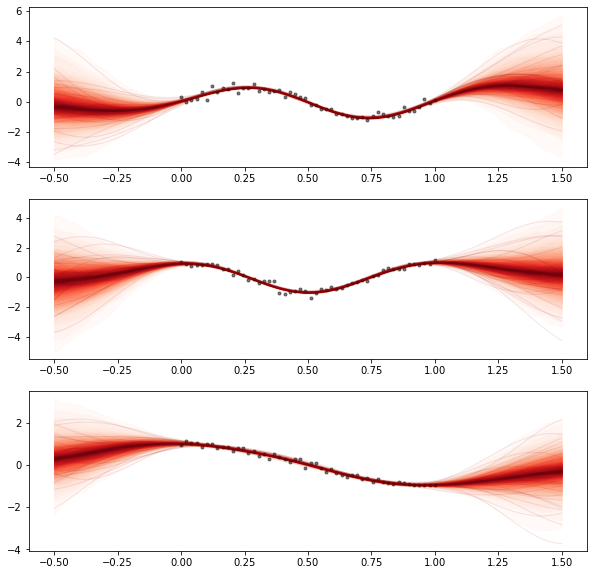

In [28]:
from pymc.gp.util import plot_gp_dist
fig, axes = plt.subplots(3,1, figsize=(10,10))

for idx in range(3):
    axes[idx].plot(x, train_y[:,idx], 'ok', ms=3, alpha=0.5, label=f"Data {idx}");
    plot_gp_dist(axes[idx], f_pred[:,Xnew[:,1] == idx], xnew,
                 fill_alpha=0.5, samples_alpha=0.1)

plt.show()

In [29]:
az.summary(gp_trace)

arviz - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"W[0, 0]",-0.242,2.225,-3.968,4.346,0.149,0.105,226.0,302.0,NaN
"W[0, 1]",-0.027,2.366,-4.431,4.229,0.168,0.119,201.0,367.0,NaN
"W[1, 0]",0.181,2.179,-4.214,3.866,0.145,0.103,228.0,326.0,NaN
"W[1, 1]",-0.100,2.299,-3.884,4.510,0.135,0.096,301.0,358.0,NaN
"W[2, 0]",-0.126,1.143,-2.565,1.843,0.063,0.056,336.0,281.0,NaN
"W[2, 1]",0.082,1.245,-2.098,2.680,0.067,0.067,421.0,271.0,NaN
ell,0.336,0.046,0.254,0.418,0.002,0.002,357.0,354.0,NaN
eta,0.662,0.267,0.283,1.140,0.020,0.015,255.0,260.0,NaN
kappa[0],1.819,1.386,0.042,4.395,0.054,0.039,438.0,270.0,NaN
kappa[1],1.894,1.474,0.042,4.701,0.055,0.040,519.0,238.0,NaN


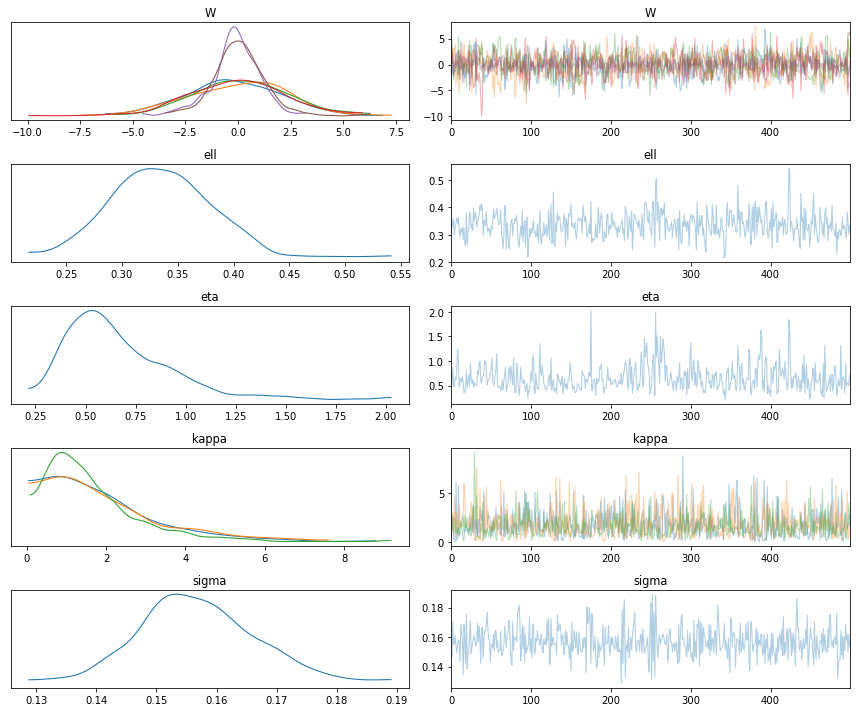

In [30]:
az.plot_trace(gp_trace);
plt.tight_layout()

### Option 2.2: Implement LCM by using pm.gp.cov.Kron with pm.gp.Marginal

In [31]:
X = pm.math.cartesian(x, task_i)
x.shape, task_i.shape, X.shape

((50, 1), (3, 1), (150, 2))

In [32]:
with pm.Model() as model:
    ell = pm.Gamma("ell", alpha=2, beta=0.5)
    eta = pm.Gamma("eta", alpha=3, beta=1)
    cov = eta**2 * pm.gp.cov.ExpQuad(1, ls=ell)
    
    ell2 = pm.Gamma("ell2", alpha=2, beta=0.5)
    eta2 = pm.Gamma("eta2", alpha=3, beta=1)
    cov2 = eta2**2 * pm.gp.cov.Matern32(1, ls=ell2)
    
    W = pm.Normal("W", mu=0, sigma=3, shape=(3,2), initval=np.random.randn(3,2))
    kappa = pm.Gamma("kappa", alpha=1.5, beta=1, shape=3)
    coreg = pm.gp.cov.Coregion(input_dim=1, kappa=kappa, W=W)    
    
    cov_func = pm.gp.cov.Kron([cov+cov2, coreg])    
    sigma = pm.HalfNormal("sigma", sigma=3)    
    gp = pm.gp.Marginal(cov_func=cov_func)    
    y_ = gp.marginal_likelihood("f", X, y.squeeze(), noise=sigma)

In [33]:
cov(x).eval().shape, coreg(task_i).eval().shape, cov_func(X).eval().shape

((50, 50), (3, 3), (150, 150))

In [34]:
%%time
with model:
    gp_trace = pm.sample(500, chains=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [ell, eta, ell2, eta2, W, kappa, sigma]


Sampling 1 chain for 1_000 tune and 500 draw iterations (1_000 + 500 draws total) took 106 seconds.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.


CPU times: user 5min 9s, sys: 9min, total: 14min 9s
Wall time: 1min 52s


#### Prediction

In [35]:
xnew = np.linspace(-0.5, 1.5, 200)
Xnew = pm.math.cartesian(xnew, task_i)

In [36]:
with model:
    preds = gp.conditional("preds", Xnew, jitter=1e-6)
    gp_samples = pm.sample_posterior_predictive(gp_trace, var_names=['preds'])

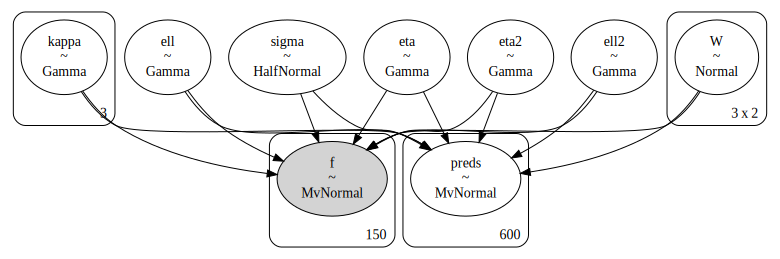

In [37]:
pm.model_to_graphviz(model)

In [38]:
Xnew.shape

(600, 2)

In [39]:
f_pred = gp_samples.posterior_predictive["preds"].sel(chain=0)
f_pred.shape

(500, 600)

#### Plot the GP prediction

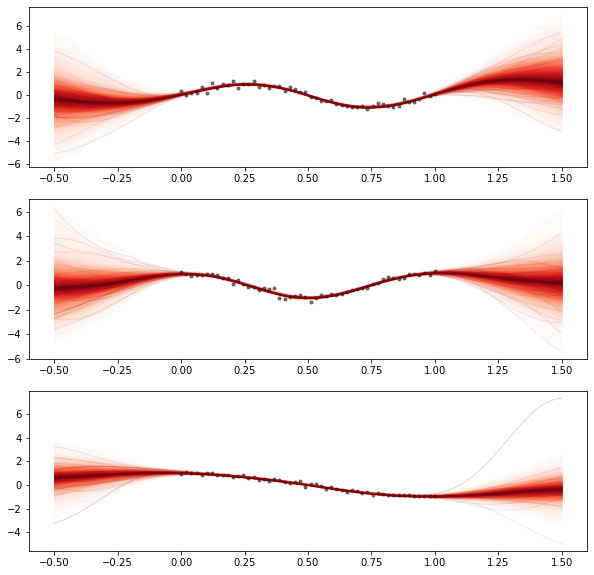

In [40]:
from pymc.gp.util import plot_gp_dist
fig, axes = plt.subplots(3,1, figsize=(10,10))

for idx in range(3):
    axes[idx].plot(x, train_y[:,idx], 'ok', ms=3, alpha=0.5, label=f"Data {idx}");
    plot_gp_dist(axes[idx], f_pred[:,Xnew[:,1] == idx], xnew,
                 fill_alpha=0.5, samples_alpha=0.1)

plt.show()

In [41]:
az.summary(gp_trace)

arviz - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"W[0, 0]",-0.118,1.857,-3.488,3.157,0.117,0.082,262.0,153.0,NaN
"W[0, 1]",-0.280,2.027,-4.231,2.991,0.196,0.139,116.0,135.0,NaN
"W[1, 0]",-0.228,2.037,-4.538,3.239,0.176,0.125,132.0,195.0,NaN
"W[1, 1]",0.127,1.904,-3.836,3.181,0.106,0.080,321.0,281.0,NaN
"W[2, 0]",0.034,0.943,-1.573,1.839,0.047,0.055,423.0,233.0,NaN
"W[2, 1]",-0.050,0.931,-1.898,1.719,0.062,0.058,292.0,149.0,NaN
ell,0.403,0.167,0.247,0.783,0.042,0.031,44.0,22.0,NaN
eta,0.918,0.424,0.308,1.685,0.027,0.019,281.0,259.0,NaN
ell2,4.459,2.701,0.598,9.015,0.294,0.208,52.0,164.0,NaN
eta2,1.007,0.672,0.124,2.361,0.093,0.073,104.0,83.0,NaN


In [42]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Sun Sep 04 2022

Python implementation: CPython
Python version       : 3.9.12
IPython version      : 8.3.0

matplotlib: 3.5.2
pymc      : 4.1.5
arviz     : 0.12.1
numpy     : 1.22.4

Watermark: 2.3.0

